# 第1题

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用黑体（适用于中文）
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
plt.style.use('fivethirtyeight')  # 设置绘图风格
np.random.seed(0)  # 设置随机种子

# 第一题

In [34]:
# 奇异值软阈值函数（Singular Value Thresholding）
def svt(M, tau):
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    S_threshold = np.maximum(S - tau, 0)
    return U @ np.diag(S_threshold) @ Vt

# l21范数的列缩放操作
def solve_l21(R, lambd_over_beta):
    E = np.zeros_like(R)
    for j in range(R.shape[1]):
        norm = np.linalg.norm(R[:, j])
        if norm > lambd_over_beta:
            E[:, j] = (1 - lambd_over_beta / norm) * R[:, j]
    return E

# 主优化函数
def ladmap_matrix_decomposition(D, lambd=0.01, eps1=1e-6, eps2=1e-5, beta0=None, beta_max=1e10, rho0=1.9, max_iter=5000):
    m, n = D.shape
    Z = np.zeros((n, n))
    E = np.zeros_like(D)
    Y1 = np.zeros_like(D)
    Y2 = np.zeros((n, 1))

    beta = beta0 if beta0 is not None else min(n, m) * eps2
    eta_D = 2.02 * (np.linalg.norm(D, 2) ** 2)

    one = np.ones((n, 1))

    history = {'res_primal': [], 'res_dual': []}

    for k in range(max_iter):
        # 更新Z
        term1 = D.T @ (D @ Z + E - D)
        term2 = one @ ((Z.T @ one - one).T)
        term3 = (1 / beta) * D.T @ Y1
        term4 = (1 / beta) * one @ Y2.T

        G = Z - (1 / eta_D) * (term1 + term2 + term3 + term4)
        Z_new = svt(G, 1 / (eta_D * beta))

        # 更新E
        R = D - D @ Z + (1 / beta) * Y1
        E_new = solve_l21(R, lambd / beta)

        # 更新乘子
        Y1 += beta * (D - D @ Z_new - E_new)
        Y2 += beta * (Z_new.T @ one - one)

        # 收敛判断
        res_primal = np.linalg.norm(D - D @ Z_new - E_new) / np.linalg.norm(D)
        res_dual = max(
            np.linalg.norm(Z_new - Z) / np.linalg.norm(D),
            np.linalg.norm(E_new - E) / np.linalg.norm(D)
        )

        history['res_primal'].append(res_primal)
        history['res_dual'].append(res_dual)

        if res_primal < eps1 or res_dual < eps2:
            break

        # 自适应更新 beta
        if beta * max(np.sqrt(eta_D) * np.linalg.norm(Z_new - Z), np.linalg.norm(E_new - E)) / np.linalg.norm(D) < eps2:
            beta = min(rho0 * beta, beta_max)

        Z, E = Z_new, E_new

    return Z, E, history

In [35]:
# 生成示例数据
np.random.seed(0)
m, n = 200, 300
Z_true = np.random.randn(n, n)
D = np.random.randn(m, n) @ Z_true
D += 0.1 * np.random.randn(*D.shape)  # 添加噪声

# 执行算法
Z_est, E_est, hist = ladmap_matrix_decomposition(D)

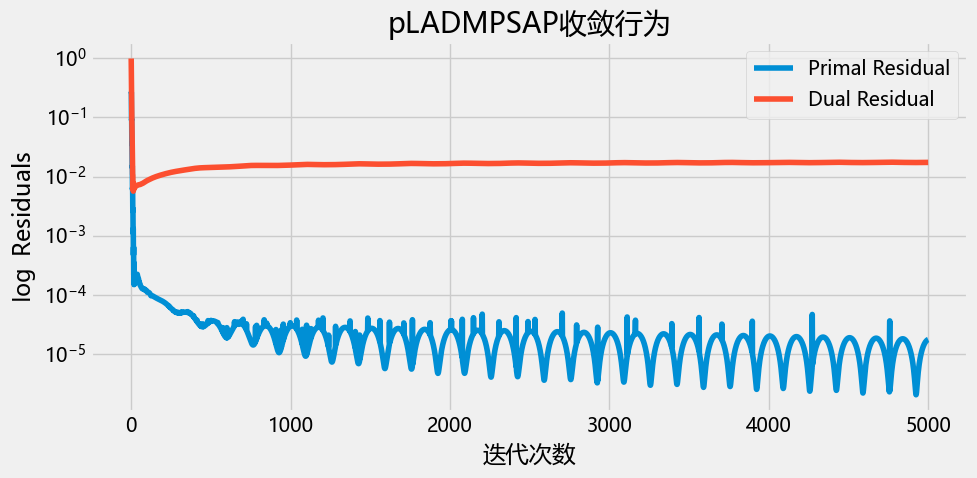

In [36]:

# 可视化收敛过程
plt.figure(figsize=(10, 5))
plt.semilogy(hist['res_primal'], label='Primal Residual')
plt.semilogy(hist['res_dual'], label='Dual Residual')
plt.xlabel('迭代次数')
plt.ylabel(r'$\log$ Residuals')
plt.title('pLADMPSAP收敛行为')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 第二题

In [24]:
def generate_data(s=100, d=20, sigma=0.1, seed=42):
    np.random.seed(seed)
    X = np.random.randn(s, d)
    w_true = np.random.randn(d)
    y = np.sign(X @ w_true + sigma * np.random.randn(s))
    return X, y

def logistic_loss_grad(w, X, y, s):
    z = y * (X @ w)
    sig = 1 / (1 + np.exp(-z))
    grad = - (1 / s) * (X.T @ ((1 - sig) * y))
    return grad

def gradient_descent(X, y, lr=0.1, max_iter=500, tol=1e-6):
    s = X.shape[0]
    w = np.zeros(X.shape[1])
    loss_list = []
    for i in range(max_iter):
        grad = logistic_loss_grad(w, X, y, s)
        w -= lr * grad
        loss = np.mean(np.log(1 + np.exp(-y * (X @ w))))
        loss_list.append(loss)
        if np.linalg.norm(grad) < tol:
            break
    return w, loss_list


In [32]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(w, x, y):
    return np.log(1 + np.exp(-y * (x @ w)))

def grad_logistic_loss(w, x, y):
    z = y * (x @ w)
    sig = sigmoid(-z)
    return -sig * y * x

def update_wi(wi, w, alpha_i, x_i, y_i, rho, s, eta=0.1, max_inner=5):
    # gradient descent on local subproblem (smooth + quadratic)
    for _ in range(max_inner):
        grad = (1 / s) * grad_logistic_loss(wi, x_i, y_i) + alpha_i + rho * (wi - w)
        wi -= eta * grad
    return wi

def pLADMPSAP(X, y, rho=1.0, max_iter=500, tol=1e-6):
    s, d = X.shape
    w_i = np.zeros((s, d))
    w = np.zeros(d)
    alpha = np.zeros((s, d))
    losses = []

    for it in range(max_iter):
        # 1. update local w_i
        for i in range(s):
            w_i[i] = update_wi(w_i[i], w, alpha[i], X[i], y[i], rho, s)

        # 2. update central w
        w = (1.0 / s) * np.sum(w_i + (1 / rho) * alpha, axis=0)

        # 3. update dual alpha
        for i in range(s):
            alpha[i] += rho * (w_i[i] - w)

        # Compute total loss
        loss = np.mean([logistic_loss(w_i[i], X[i], y[i]) for i in range(s)])
        losses.append(loss)

        # Check convergence
        primal_res = np.linalg.norm(w_i - w, ord='fro')
        if primal_res < tol:
            break

    return w, losses

In [38]:
import matplotlib.pyplot as plt

def plot_loss(loss_list1, loss_list2, label1='GD', label2='pLADMPSAP'):
    plt.plot(loss_list1, label=label1)
    plt.plot(loss_list2, label=label2)
    plt.xlabel("迭代次数")
    plt.ylabel("Loss")
    plt.title("收敛行为比较")
    plt.legend()
    plt.grid(True)
    plt.show()


In [39]:
X, y = generate_data(s=30, d=20)
maxiter = 10000

w_gd, loss_gd = gradient_descent(X, y, max_iter=maxiter)
w_admm, loss_admm = pLADMPSAP(X, y, max_iter=maxiter)

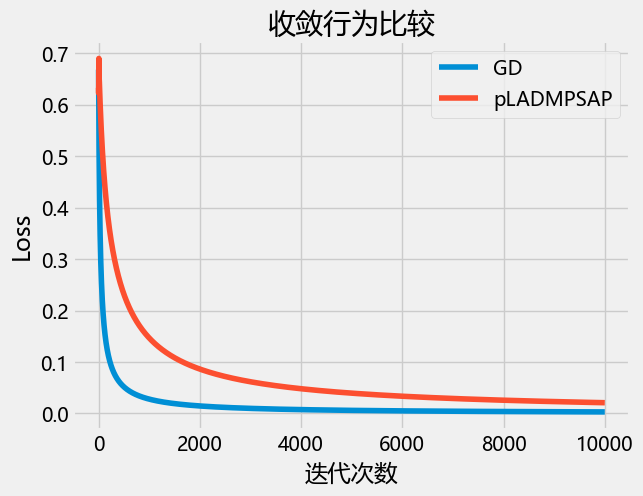

In [ ]:

plot_loss(loss_gd, loss_admm, label1='GD', label2='pLADMPSAP')

# 第三题

In [48]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

def normalize_columns(D):
    return D / np.linalg.norm(D, axis=0, keepdims=True)

def update_X(Y, D, lambd):
    X = np.zeros((D.shape[1], Y.shape[1]))
    for i in range(Y.shape[1]):
        lasso = Lasso(alpha=lambd, fit_intercept=False, max_iter=1000)
        lasso.fit(D, Y[:, i])
        X[:, i] = lasso.coef_
    return X

def update_D(Y, X, epsilon=1e-3):
    # Ridge 回归方式：加入正则项，防止 X @ X.T 奇异
    XXT = X @ X.T + epsilon * np.eye(X.shape[0])
    D = Y @ X.T @ np.linalg.inv(XXT)
    return normalize_columns(D)


def dictionary_learning(Y, K=400, lambd=0.01, max_iter=20):
    m, n = Y.shape
    D = np.random.randn(m, K)
    D = normalize_columns(D)
    losses = []

    for it in range(max_iter):
        X = update_X(Y, D, lambd)
        D = update_D(Y, X)
        loss = 0.5 * np.linalg.norm(Y - D @ X, 'fro')**2 + lambd * np.sum(np.abs(X))
        losses.append(loss)
        print(f"Iter {it+1}, loss: {loss:.4f}")
    
    return D, X, losses

In [49]:
# 生成数据
np.random.seed(0)
Y = np.random.randn(200, 500)  # Y ∈ ℝ^{200×500}

# 运行算法
D, X, losses = dictionary_learning(Y, K=400, lambd=0.01, max_iter=500)


Iter 1, loss: 44303.8327
Iter 2, loss: 30009.6437
Iter 3, loss: 17822.3215
Iter 4, loss: 12875.5022
Iter 5, loss: 11260.1805
Iter 6, loss: 10389.3136
Iter 7, loss: 9871.7931
Iter 8, loss: 9546.2562
Iter 9, loss: 9312.1048
Iter 10, loss: 9131.8257
Iter 11, loss: 8990.9927
Iter 12, loss: 8877.2877
Iter 13, loss: 8781.2406
Iter 14, loss: 8686.5676
Iter 15, loss: 8598.1785
Iter 16, loss: 8508.4919
Iter 17, loss: 8422.5709
Iter 18, loss: 8340.6412
Iter 19, loss: 8262.1991
Iter 20, loss: 8188.0925
Iter 21, loss: 8120.3591
Iter 22, loss: 8059.7604
Iter 23, loss: 8015.2544
Iter 24, loss: 7983.8391
Iter 25, loss: 7960.7621
Iter 26, loss: 7940.5335
Iter 27, loss: 7920.1065
Iter 28, loss: 7900.5541
Iter 29, loss: 7882.7771
Iter 30, loss: 7870.3378
Iter 31, loss: 7860.6710
Iter 32, loss: 7851.9084
Iter 33, loss: 7842.0450
Iter 34, loss: 7833.4717
Iter 35, loss: 7826.7329
Iter 36, loss: 7821.4795
Iter 37, loss: 7817.1765
Iter 38, loss: 7814.0369
Iter 39, loss: 7811.6268
Iter 40, loss: 7808.9754
Ite

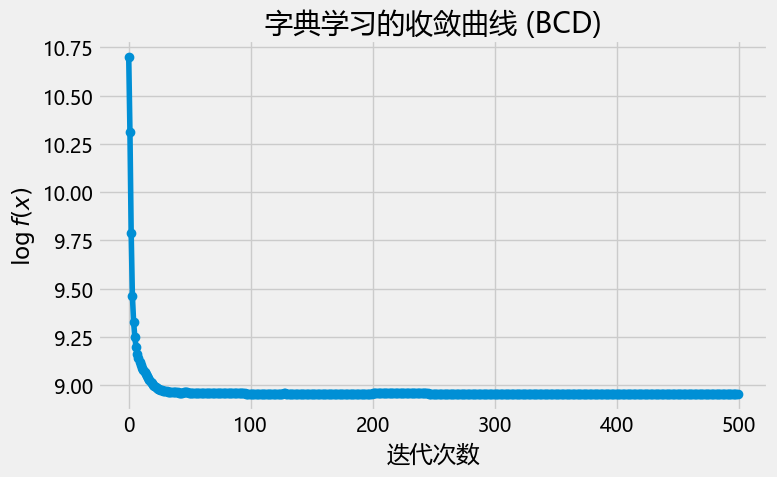

In [ ]:
# 绘制收敛曲线
plt.figure(figsize=(8,5))
plt.plot(np.log(losses), marker='o')
plt.xlabel('迭代次数')
plt.ylabel(r'$\log f(x)$')
plt.title('字典学习的收敛曲线 (BCD)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 第4题

## 不正交化

In [17]:
def bcd_track_loss(D, Omega, r, D_true, max_iter=50, orthogonalize_U=False):
    m, n = D.shape
    U = np.random.randn(m, r)
    V = np.random.randn(n, r)

    loss_list = []

    for it in range(max_iter):
        # Step 1: 更新 A
        A = U @ V.T
        A[Omega] = D[Omega]

        # Step 2: 更新 U
        VtV_inv = np.linalg.inv(V.T @ V)
        U = A @ V @ VtV_inv
        if orthogonalize_U:
            U, _ = np.linalg.qr(U)

        # Step 3: 更新 V
        UtU_inv = np.linalg.inv(U.T @ U)
        V = A.T @ U @ UtU_inv

        # Step 4: 记录当前目标函数值
        loss = np.linalg.norm(A - D_true, 'fro')
        loss_list.append(loss)

    return loss_list


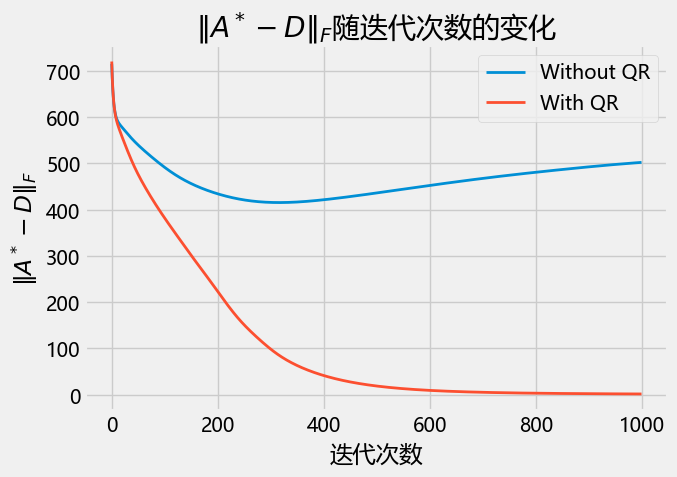

In [ ]:
np.random.seed(0)
m, n, r = 200, 300, 5

# 构造真实低秩矩阵 D_true = U_true @ V_true.T
U_true = np.random.randn(m, r)
V_true = np.random.randn(n, r)
D_true = U_true @ V_true.T

# 生成观测掩码 Omega（观测比例为 p）
p = 0.1  # 观测比例
Omega = np.random.rand(m, n) < p

# 构造观测矩阵 D，未观测位置设为 0
D = np.zeros((m, n)) # 此D非下图中的D，此D是P_\Omega(D)
D[Omega] = D_true[Omega]

maxiter = 1000
# 运行两种设置
loss_no_qr = bcd_track_loss(D, Omega, r=5, D_true = D_true, max_iter=maxiter, orthogonalize_U=False)
loss_with_qr = bcd_track_loss(D, Omega, r=5, D_true = D_true, max_iter=maxiter, orthogonalize_U=True)

# 可视化比较
plt.figure(figsize=(7, 5))
plt.plot(loss_no_qr, label='Without QR', linewidth=2)
plt.plot(loss_with_qr, label='With QR', linewidth=2)
# plt.axhline(np.linalg.norm(D_true - D, 'fro'), color='gray', linestyle='--', lw= 1, label=r'$\|D_{true} - D\|_F$')
plt.xlabel('迭代次数')
plt.ylabel(r'$ \|A^* - D\|_F $')
plt.title(r'$ \|A^* - D\|_F $随迭代次数的变化')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 第5题

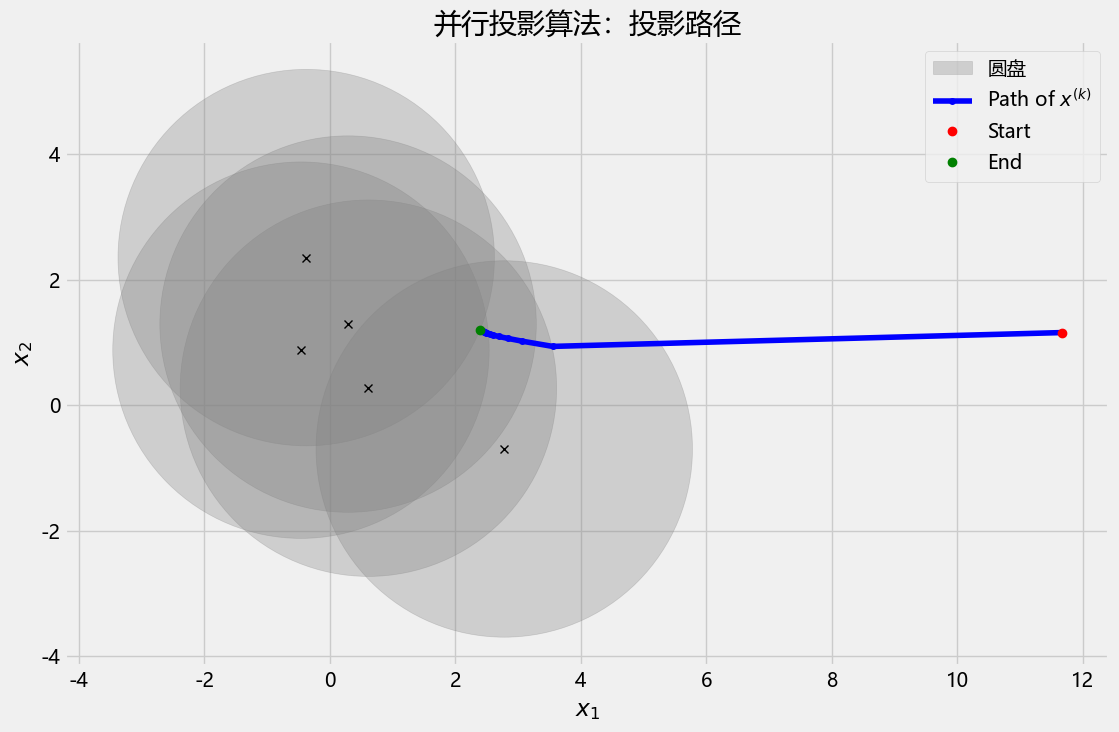

In [27]:
# 初始化参数
np.random.seed(0)
m = 5
n = 2
max_iters = 100

# 随机生成圆心和半径（保证有交集）
centers = np.random.uniform(-3, 3, size=(m, n))
radii = np.ones(m) * 3.0

# 初始化 x
x = np.random.uniform(-20, 20, size=n)
x_history = [x.copy()]

# 投影到圆盘的函数
def project_to_disk(x, center, radius):
    diff = x - center
    dist = np.linalg.norm(diff)
    if dist <= radius:
        return x
    else:
        return center + radius * diff / dist

# 迭代
for _ in range(max_iters):
    y_list = np.array([project_to_disk(x, centers[i], radii[i]) for i in range(m)])
    x = np.mean(y_list, axis=0)
    x_history.append(x.copy())

x_history = np.array(x_history)

# 绘图：显示投影路径和圆盘
fig, ax = plt.subplots(figsize=(12, 12))

# 画圆
for i in range(m):
    circle = plt.Circle(centers[i], radii[i], color='gray', alpha=0.3, label=f"圆盘" if i == 0 else None)
    ax.add_patch(circle)
    ax.plot(*centers[i], 'kx')

# 投影路径
ax.plot(x_history[:, 0], x_history[:, 1], 'bo-', markersize=4, label='Path of $x^{(k)}$')
ax.plot(*x_history[0], 'ro', label='Start')
ax.plot(*x_history[-1], 'go', label='End')

ax.set_aspect('equal')
ax.set_title('并行投影算法：投影路径')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend()
plt.grid(True)
plt.show()
